In [476]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler



In [477]:
# Load the dataset into a DataFrame
# df = pd.read_csv('data/kc_house_data.csv')
df = pd.read_csv('data/updated_housing.csv')

Checking info, nulls

In [478]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29211 entries, 0 to 29210
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29211 non-null  int64  
 1   date           29211 non-null  object 
 2   price          29211 non-null  float64
 3   bedrooms       29211 non-null  int64  
 4   bathrooms      29211 non-null  float64
 5   sqft_living    29211 non-null  int64  
 6   sqft_lot       29211 non-null  int64  
 7   floors         29211 non-null  float64
 8   waterfront     29211 non-null  object 
 9   greenbelt      29211 non-null  object 
 10  nuisance       29211 non-null  object 
 11  view           29211 non-null  object 
 12  condition      29211 non-null  object 
 13  grade          29211 non-null  object 
 14  heat_source    29182 non-null  object 
 15  sewer_system   29198 non-null  object 
 16  sqft_above     29211 non-null  int64  
 17  sqft_basement  29211 non-null  int64  
 18  sqft_g

- 30155 long
- Several object dtypes
- heat_source and sewer_system have nulls

### Looking further into the null and duplicate values

In [479]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      29
sewer_system     13
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
geometry          0
MHHI1             0
traffic_de        0
toxic_rele        0
hazardou_2        0
SCHDST            0
NAME              0
DSTNUM            0
dtype: int64

In [480]:
# locating duplicates
print(f'Number of Duplicates: {df.duplicated().sum()}')
df.loc[df.duplicated() == True]

Number of Duplicates: 1


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,lat,long,geometry,MHHI1,traffic_de,toxic_rele,hazardou_2,SCHDST,NAME,DSTNUM
24338,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,...,47.68069,-122.172135,POINT (-122.172135 47.680690000000006),95625.0,6.0,3786.715617,2.0,414,Lake Washington,17414


### Function for droping duplicates, nulls, and other specified columns

In [481]:
def dropper(df, one=None, two=None, three=None):
    '''
    Input: DataFrame, request 1,request 2, request 3
    requests:
    'duplicates' to drop duplicates
    'nulls' to drop null values
    list containing df column names l = ['','','']
    '''
    request = [one,two,three]
    if 'duplicates' in request:
        df = df.drop_duplicates()
    if 'nulls' in request:
        df = df.dropna()
    for req in request:
        if isinstance(req, list):
            df = df.drop(columns=req, axis=1).reset_index(drop=True)
    return(df)

- below we drop duplicates and null values, in total there is only 1 duplicated row and 42 null values

In [482]:
droping =['id','geometry','address','NAME','DSTNUM','date','lat','long']
df_clean = dropper(df, 'duplicates', 'nulls', droping)

### Checking for Catagoricals

In [483]:
categoricals = df_clean.select_dtypes("object")

for col in categoricals:
    print(df_clean[col].value_counts(), "\n")

NO     28664
YES      506
Name: waterfront, dtype: int64 

NO     28401
YES      769
Name: greenbelt, dtype: int64 

NO     24166
YES     5004
Name: nuisance, dtype: int64 

NONE         25651
AVERAGE       1891
GOOD           868
EXCELLENT      545
FAIR           215
Name: view, dtype: int64 

Average      17581
Good          8046
Very Good     3258
Fair           224
Poor            61
Name: condition, dtype: int64 

7 Average        11547
8 Good            8852
9 Better          3587
6 Low Average     2848
10 Very Good      1347
11 Excellent       402
5 Fair             385
12 Luxury          122
4 Low               46
13 Mansion          24
3 Poor               9
2 Substandard        1
Name: grade, dtype: int64 

Gas                  20147
Electricity           5950
Oil                   2899
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64 

PUBLIC                24833
PRIVATE               

# converting to numeric types

In [484]:
def numeric_housing(df): 
    '''
    This function converts all boolean or rating types into numerics from input df. 
    this is saved as df_numeric
    This only works with housing data
    '''
    
    def convert_boolean(df,x=None):
        '''
        This function converts all boolean data into numeric types
        Used in numeric_df
        input dataframe
        '''
        boolean_cols = df.select_dtypes(include='object').columns
        column_name = []
        for col in boolean_cols:
            if set(df[col].unique()) == {'YES', 'NO'}:
                df[col] = df[col].replace({"NO": 0, "YES": 1})
                column_name.append(col)

        print(f'Boolean Conversions:{column_name}')
        return(df)

    df_numeric = df.copy()

    # Returns the new df_clean and lists the columns changed
    convert_boolean(df_numeric,1)

    # adjusting view column 
    # View has no intupretation written so it was self interpreted
#     df_numeric["view"] = df_numeric["view"].replace({"NONE": 0, "FAIR": 1, "AVERAGE": 2, "GOOD": 3, "EXCELLENT": 4,})

    # adjusting condition column 
    # View https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c 
    # under building condition it lists the order
    df_numeric["condition"] = df_numeric["condition"].replace({"Poor": 0, "Fair": 1, "Average": 2,
                                                               "Good": 3, "Very Good": 4,})
                                                
        
    # adjusting grade column 
    # View https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c 
    # under building grade it lists the order
    # they list the assosiated number with in name, i replaced it to just be the number
    df_numeric["grade"] = df_numeric["grade"].replace({"2 Substandard": 2,  "3 Poor": 3, "4 Low": 4, "5 Fair": 5,
                                                       "6 Low Average": 6, "7 Average": 7, "8 Good": 8, 
                                                       "9 Better": 9, "10 Very Good": 10, "11 Excellent": 11, 
                                                       "12 Luxury": 12, "13 Mansion": 13,})
                               
    df_numeric['renovated']= df_numeric['yr_renovated'].apply(lambda x: 1 if x !=0 else 0)
    df_numeric = df_numeric.drop(columns='yr_renovated')
    
    adjusted = ['view','condition', 'grade','date']
    
    print(f'Rating Conversions: {adjusted}')
#     print(display(df_numeric.head()))
    return(df_numeric)
df_clean = numeric_housing(df_clean)

Boolean Conversions:['waterfront', 'greenbelt', 'nuisance']
Rating Conversions: ['view', 'condition', 'grade', 'date']


# Creating Dummy variables

In [485]:
def for_dummies(df,columns):
    '''
    (dataframe, column name or list)
    creates a dummy variable for each specified column, 
    drops column with heighest value count
    columns: 'column' or ['column1','column2',...]
    '''
    if isinstance(columns, str):
        columns = [columns]
    for column in columns:
        dropped = str(df[column].value_counts().idxmax())
        name_drop = column + '_' +dropped
        print(f'Dropped Column: {name_drop}')
        df_dum = pd.get_dummies(df, columns=[column], drop_first=False)
        df_dum = df_dum.drop(columns=name_drop)
        df = df_dum
    return(df)

In [486]:
# Changing type of SCHDST for int to object
df_clean['SCHDST'] = df_clean['SCHDST'].astype(object)
dum_list = ['SCHDST','view', 'sewer_system']
df_clean = for_dummies(df_clean, dum_list)


Dropped Column: SCHDST_1
Dropped Column: view_NONE
Dropped Column: sewer_system_PUBLIC


In [487]:
df_clean

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,SCHDST_415,SCHDST_417,SCHDST_888,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC RESTRICTED
0,675000.0,4,1.0,1180,7140,1.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,728000.0,4,2.0,2170,7520,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,645000.0,3,2.0,1520,8250,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,760600.0,3,2.5,2570,2889,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,624950.0,3,2.5,1610,8625,1.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,380000.0,2,1.0,800,9927,1.5,0,0,1,2,...,0,0,0,0,0,0,0,1,0,0
29166,199000.0,2,1.0,1150,10098,1.5,0,0,1,2,...,0,0,0,1,0,0,0,1,0,0
29167,395000.0,1,1.0,620,10400,1.5,0,0,1,2,...,0,0,0,0,0,0,0,1,0,0
29168,328000.0,2,1.5,980,5000,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


# Dropping all left over object dtypes

In [488]:
df_object = df_clean.select_dtypes(include='object')
print(f'The following columns were dropped due to being object types\n{df_object.columns}')
df_clean = df_clean.drop(df_object,axis=1)

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


# Removing Outliers 

In [304]:
df_zscore = df_clean.apply(stats.zscore)
df_zscore

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,yr_renovated_2016,yr_renovated_2017,yr_renovated_2018,yr_renovated_2019,yr_renovated_2020,yr_renovated_2021,yr_renovated_2022
0,-0.488895,0.576730,-1.489927,-0.974068,-0.164133,-0.942031,-0.132864,-0.164549,-0.455047,0.724182,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
1,-0.429707,0.576730,-0.371840,0.039630,-0.157886,-0.942031,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
2,-0.522397,-0.447141,-0.371840,-0.625930,-0.145885,-0.942031,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
3,-0.393302,-0.447141,0.187204,0.449205,-0.234017,0.881880,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
4,-0.544788,-0.447141,0.187204,-0.533775,-0.139720,-0.942031,-0.132864,-0.164549,-0.455047,0.724182,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,-0.818333,-1.471012,-1.489927,-1.363165,-0.118316,-0.030075,-0.132864,-0.164549,2.197575,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
29166,-1.020463,-1.471012,-1.489927,-1.004786,-0.115505,-0.030075,-0.132864,-0.164549,2.197575,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
29167,-0.801582,-2.494883,-1.489927,-1.547473,-0.110540,-0.030075,-0.132864,-0.164549,2.197575,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115
29168,-0.876404,-1.471012,-0.930884,-1.178856,-0.199313,0.881880,-0.132864,-0.164549,-0.455047,-0.688443,...,-0.033139,-0.031546,-0.031546,-0.036589,-0.036117,-0.038867,-0.03466,-0.030997,-0.048693,-0.021115


In [305]:
df_no_outliers = df_clean[(np.abs(df_clean.apply(stats.zscore)) < 3).all(axis=1)]

In [306]:
df_no_outliers

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,yr_renovated_2016,yr_renovated_2017,yr_renovated_2018,yr_renovated_2019,yr_renovated_2020,yr_renovated_2021,yr_renovated_2022
1612,705000.0,2,1.0,1260,8036,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1614,575000.0,2,2.5,1290,2073,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1615,575000.0,2,2.0,1230,1000,3.0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1617,585000.0,3,2.5,1490,1537,2.0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1619,745000.0,2,2.0,1650,7560,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,1056000.0,3,3.5,1730,1349,3.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
10508,1165000.0,2,2.0,1260,2400,2.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
10509,1224950.0,2,2.0,1420,1234,3.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
10510,970000.0,3,2.0,1540,2000,1.5,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [442]:
def correlation(df,column=None,rank=None):
    '''
    performs correlation matrix, drops no numeric object types
    variables are dataframe, column, and ranking
    ranking is optional
    column = 'column'
    rank = True for # rank 1,2,3...
    
    '''
    # RRedundant check. Makes sure all columns of object type are dropped
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types\n{df_object.columns}')
    df = df.drop(df_object,axis=1) 
    df1 = df
    if rank is True:
        try:
            df_corr = df1.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Ranked correlation to {column}')
            return(df_corr.rank(ascending=False).sort_values())
        except:
            df_corr = df1.corr()
            return(df_corr.rank(ascending=False))
    else:    
        try:
            df_corr = df.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Correlation to {column}')
            return(df_corr.sort_values(ascending=False))
        except:
            df_corr = df1.corr()
            return(df_corr)

In [623]:
df_corr[['price']].sort_values(by='price',ascending=False)

,price
price,1.000000
sqft_living,0.616625
grade,0.577978
sqft_above,0.546001
bathrooms,0.487829
MHHI1,0.480884
sqft_patio,0.317543
hazardou_2,0.308898
SCHDST_405,0.303652
view_EXCELLENT,0.292536


### Correlation to price

The following columns were dropped due to being object types
Index([], dtype='object')


Text(0.5, 1.0, 'Variables Correlating with Price')

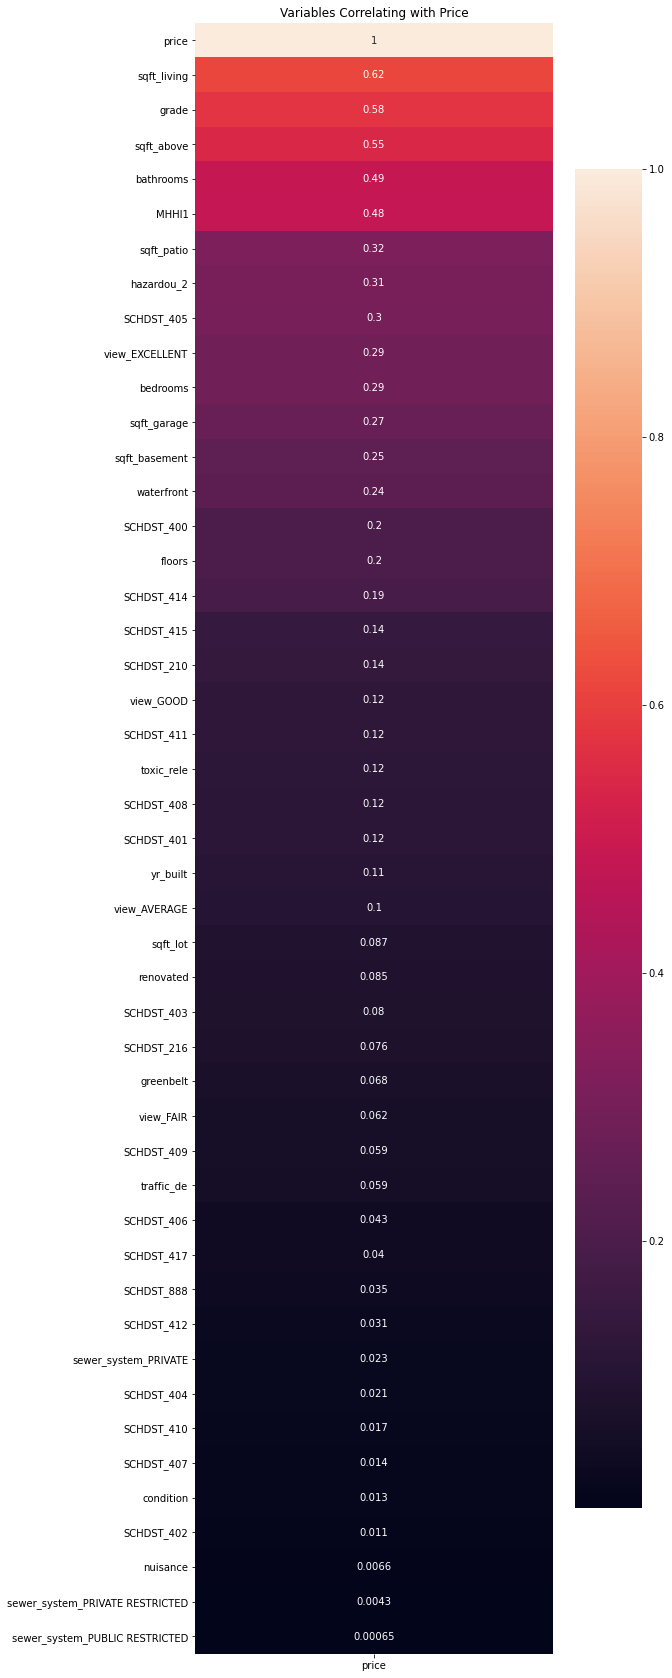

In [618]:
df_corr = abs(correlation(df_clean))
fig, ax = plt.subplots(figsize=(8,30))
sns.heatmap(df_corr[['price']].sort_values(by='price',ascending=False), annot=True)

ax.set_title('Variables Correlating with Price')

<AxesSubplot:>

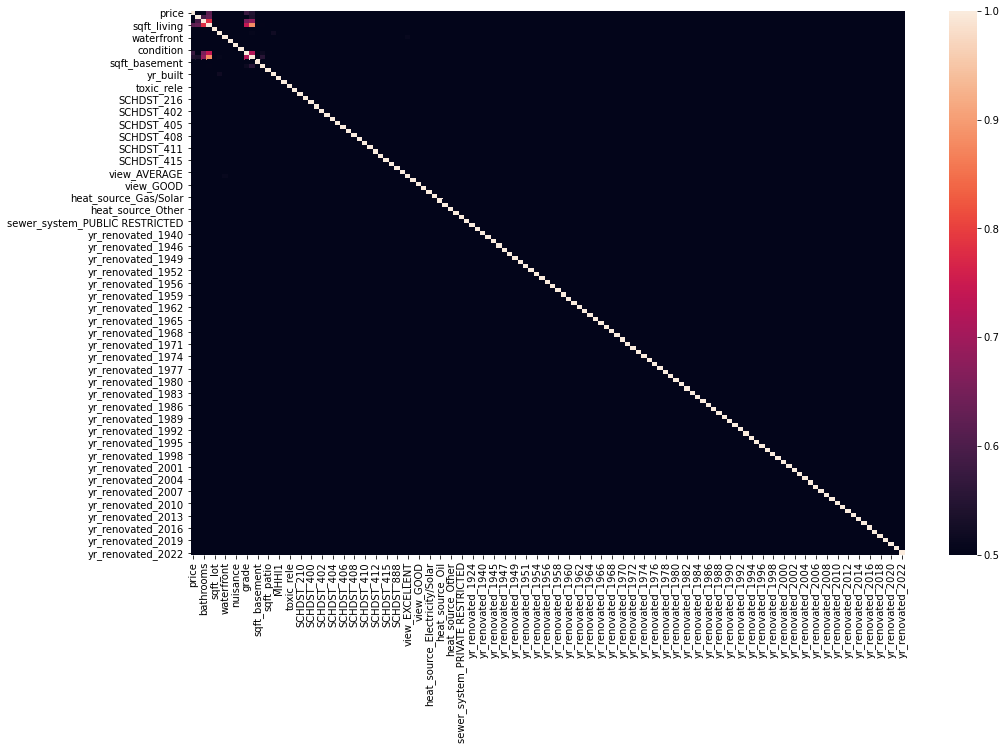

In [331]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(abs(df_clean.corr()), annot=False,ax=ax,vmin=.5)

<AxesSubplot:>

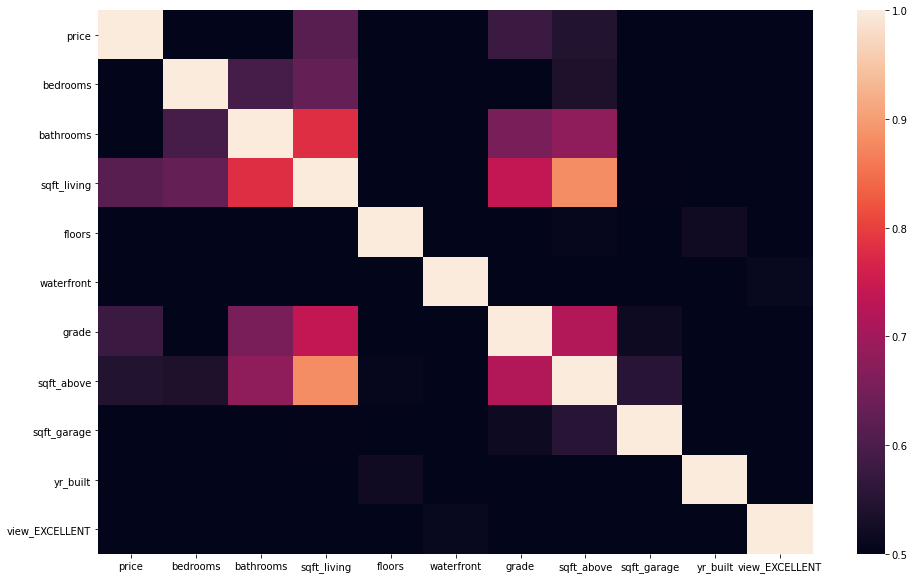

In [332]:
df_cc = abs(df_clean.corr())
threshold = (df_cc > .5) & (df_cc < 1)
df_ccf = df_cc.loc[threshold.any(axis=1),threshold.any(axis=0)]
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_ccf, annot=False,ax=ax,vmin=.5)

In [333]:
# stack creates a series of tuples
filters = df_ccf[threshold].stack()

# sorts each tuple so any xy and yx will now all be xy and xy
# when using sorted each variable becomes a list so they need to be converted back to a tuple
#lastly now peform a set on the tuples
filtered = set(tuple(sorted(l,reverse=True)) for l in list(filters.index))
# for f in filtered:
print(f'Highley correlating variables:\n')
list(map(print, sorted(filtered)));

Highley correlating variables:

('bedrooms', 'bathrooms')
('grade', 'bathrooms')
('price', 'grade')
('sqft_above', 'bathrooms')
('sqft_above', 'bedrooms')
('sqft_above', 'floors')
('sqft_above', 'grade')
('sqft_above', 'price')
('sqft_garage', 'grade')
('sqft_garage', 'sqft_above')
('sqft_living', 'bathrooms')
('sqft_living', 'bedrooms')
('sqft_living', 'grade')
('sqft_living', 'price')
('sqft_living', 'sqft_above')
('sqft_living', 'sqft_garage')
('waterfront', 'view_EXCELLENT')
('yr_built', 'floors')


sqft living & Bathrooms


# Creating Regression Models

In [619]:
list(df_clean.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'greenbelt',
 'nuisance',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'MHHI1',
 'traffic_de',
 'toxic_rele',
 'hazardou_2',
 'renovated',
 'SCHDST_210',
 'SCHDST_216',
 'SCHDST_400',
 'SCHDST_401',
 'SCHDST_402',
 'SCHDST_403',
 'SCHDST_404',
 'SCHDST_405',
 'SCHDST_406',
 'SCHDST_407',
 'SCHDST_408',
 'SCHDST_409',
 'SCHDST_410',
 'SCHDST_411',
 'SCHDST_412',
 'SCHDST_414',
 'SCHDST_415',
 'SCHDST_417',
 'SCHDST_888',
 'view_AVERAGE',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'sewer_system_PRIVATE',
 'sewer_system_PRIVATE RESTRICTED',
 'sewer_system_PUBLIC RESTRICTED']

In [460]:
def mlr(df,column,model_t=None, simple=False):
    '''
    This runs a Multiple Linear Regression for a set list from df_numeric.
    Call an int to return the list of columns used, mlr(1)
    dataframe,y column, optional single regression add column
    simple: 
    True = simple
    False = multiple
    model_t:
    'x' = return x columns used
    'fit' = no summary
    '''
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types\n{df_object.columns}')
    df1 = df.drop(df_object,axis=1)

    
    if simple == True:
        highest_corr = correlation(df, column).abs().idxmax()
        x = df[highest_corr]
    elif simple == False:
        x = df1.drop(column, axis=1)
        
    # Define the y variables
    y = df1[column]
    # create model
    model = sm.OLS(y,sm.add_constant(x)).fit()

    if model_t == 'x':
        return(sm.add_constant(x))
    elif model_t == 'fit':
        return(model)
    
    # Model Summary
    return(model.summary())


In [573]:
mlr(df_clean,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:46:21   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.713e+06   3.34e+05      5.122      0.000    1.06e+06    2.37e+06
bedrooms                        -8.002e+04   4557.539    -17.559      0.000    -8.9e+04   -7.11e+04
bathrooms                        6.272e+04   6644.323      9.440      0.000    4.97e+04    7.57e+04
sqft_living                       130.3690     15.107      8.630      0.000     100.759     159.979
sqft_lot                            0.5480      0.058      9.414      0.000       0.434       0.662
floors                           -1.09e+05   8955.114    -12.169      0.000   -1.27e+05   -9.14e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
condition                         3.85e+04   5134.611      7.498      0.000    2.84e+04    4.86e+04
grade                            1.199e+05   5116.019     23.427      0.000     1.1e+05     1.3e+05
sqft_above                        303.3486     15.360     19.749      0.000     273.243     333.455
sqft_basement                      91.9130     11.490      8.000      0.000      69.393     114.433
sqft_garage                      -104.0133     16.488     -6.308      0.000    -136.331     -71.695
sqft_patio                         89.8445     15.019      5.982      0.000      60.407     119.281
yr_built                        -1174.2747    174.287     -6.738      0.000   -1515.886    -832.663
MHHI1                               3.9124      0.150     26.154      0.000       3.619       4.206
traffic_de                       1.225e+04   1368.593      8.948      0.000    9563.251    1.49e+04
toxic_rele                         -0.3712      0.144     -2.575      0.010      -0.654      -0.089
hazardou_2                       -3.08e+04   2977.798    -10.344      0.000   -3.66e+04    -2.5e+04
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

# Testing Scaling Numerical Variables

In [462]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Instanstiate SS from sklearn
ss = StandardScaler()

In [607]:
df_scale_1 = df_clean.copy()
# seperate dummies and non-dummies, also drop out boolean values 'waterfront','greenbelt', 'nuisance'
scale_columns = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','condition','grade','sqft_above',
                 'sqft_basement','sqft_garage','sqft_patio',
                'yr_built','MHHI1','traffic_de','toxic_rele','hazardou_2']
df_scale = df_scale_1[scale_columns]
df_dum = df_scale_1.drop(columns=scale_columns)
# Fit on data 
ss.fit(df_scale)

StandardScaler()

In [608]:
ss.mean_

array([3.43671580e+00, 2.33256771e+00, 2.13129681e+03, 1.71240494e+04,
       1.51648954e+00, 2.48735002e+00, 7.63873843e+00, 1.82611409e+03,
       4.81217689e+02, 3.36572369e+02, 2.16338258e+02, 1.97384227e+03,
       8.97680184e+04, 5.07915667e+00, 1.80221169e+04, 5.44010970e+00])

In [609]:
ss.scale_

array([9.76685315e-01, 8.94384275e-01, 9.76622269e+02, 6.08290520e+04,
       5.48272086e-01, 7.07902215e-01, 1.15240765e+00, 8.80068842e+02,
       5.86123186e+02, 2.86177674e+02, 2.46752100e+02, 3.16546756e+01,
       3.07862773e+04, 2.68495617e+00, 2.82299814e+04, 2.84382588e+00])

In [610]:
# Transform data
array_sc = ss.transform(df_scale)
df_sc = pd.DataFrame(array_sc, columns=df_scale.columns, index= list(df_scale.index))

**Joining scaled dataframe to dummies df**

In [611]:
df_full_sc = pd.concat([df_sc, df_dum], axis=1)
df_full_sc

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,...,SCHDST_415,SCHDST_417,SCHDST_888,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC RESTRICTED
0,0.576730,-1.489927,-0.974068,-0.164133,-0.942031,0.724182,-0.554264,-0.734163,-0.821018,-1.176096,...,0,0,0,0,0,0,0,0,0,0
1,0.576730,-0.371840,0.039630,-0.157886,-0.942031,-0.688443,-0.554264,-0.665987,1.294578,0.536127,...,0,0,0,0,0,0,0,0,0,0
2,-0.447141,-0.371840,-0.625930,-0.145885,-0.942031,-0.688443,0.313484,-0.722800,0.185596,0.291524,...,0,0,0,0,0,0,0,0,0,0
3,-0.447141,0.187204,0.449205,-0.234017,0.881880,-0.688443,0.313484,0.004415,0.441515,0.501184,...,0,0,0,0,0,0,0,0,0,0
4,-0.447141,0.187204,-0.533775,-0.139720,-0.942031,0.724182,0.313484,-0.756889,0.185596,0.361411,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,-1.471012,-1.489927,-1.363165,-0.118316,-0.030075,-0.688443,-3.157510,-1.165948,-0.821018,-1.176096,...,0,0,0,0,0,0,0,1,0,0
29166,-1.471012,-1.489927,-1.004786,-0.115505,-0.030075,-0.688443,-1.422013,-0.768251,-0.821018,-1.176096,...,0,0,0,1,0,0,0,1,0,0
29167,-2.494883,-1.489927,-1.547473,-0.110540,-0.030075,-0.688443,-1.422013,-1.370477,-0.821018,-1.176096,...,0,0,0,0,0,0,0,1,0,0
29168,-1.471012,-0.930884,-1.178856,-0.199313,0.881880,-0.688443,-0.554264,-0.961418,-0.821018,-1.176096,...,0,0,0,0,0,0,0,0,0,0


In [612]:
mlr(df_clean,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:05:12   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.713e+06   3.34e+05      5.122      0.000    1.06e+06    2.37e+06
bedrooms                        -8.002e+04   4557.539    -17.559      0.000    -8.9e+04   -7.11e+04
bathrooms                        6.272e+04   6644.323      9.440      0.000    4.97e+04    7.57e+04
sqft_living                       130.3690     15.107      8.630      0.000     100.759     159.979
sqft_lot                            0.5480      0.058      9.414      0.000       0.434       0.662
floors                           -1.09e+05   8955.114    -12.169      0.000   -1.27e+05   -9.14e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
condition                         3.85e+04   5134.611      7.498      0.000    2.84e+04    4.86e+04
grade                            1.199e+05   5116.019     23.427      0.000     1.1e+05     1.3e+05
sqft_above                        303.3486     15.360     19.749      0.000     273.243     333.455
sqft_basement                      91.9130     11.490      8.000      0.000      69.393     114.433
sqft_garage                      -104.0133     16.488     -6.308      0.000    -136.331     -71.695
sqft_patio                         89.8445     15.019      5.982      0.000      60.407     119.281
yr_built                        -1174.2747    174.287     -6.738      0.000   -1515.886    -832.663
MHHI1                               3.9124      0.150     26.154      0.000       3.619       4.206
traffic_de                       1.225e+04   1368.593      8.948      0.000    9563.251    1.49e+04
toxic_rele                         -0.3712      0.144     -2.575      0.010      -0.654      -0.089
hazardou_2                       -3.08e+04   2977.798    -10.344      0.000   -3.66e+04    -2.5e+04
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

In [617]:
mlr(df_full_sc,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:07:00   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.221e+06   8545.901    142.887      0.000     1.2e+06    1.24e+06
bedrooms                        -7.816e+04   4451.281    -17.559      0.000   -8.69e+04   -6.94e+04
bathrooms                         5.61e+04   5942.578      9.440      0.000    4.44e+04    6.77e+04
sqft_living                      1.273e+05   1.48e+04      8.630      0.000    9.84e+04    1.56e+05
sqft_lot                         3.334e+04   3541.355      9.414      0.000    2.64e+04    4.03e+04
floors                          -5.975e+04   4909.839    -12.169      0.000   -6.94e+04   -5.01e+04
condition                        2.725e+04   3634.802      7.498      0.000    2.01e+04    3.44e+04
grade                            1.381e+05   5895.740     23.427      0.000    1.27e+05     1.5e+05
sqft_above                        2.67e+05   1.35e+04     19.749      0.000     2.4e+05    2.93e+05
sqft_basement                    5.387e+04   6734.274      8.000      0.000    4.07e+04    6.71e+04
sqft_garage                     -2.977e+04   4718.613     -6.308      0.000    -3.9e+04   -2.05e+04
sqft_patio                       2.217e+04   3705.854      5.982      0.000    1.49e+04    2.94e+04
yr_built                        -3.717e+04   5517.011     -6.738      0.000    -4.8e+04   -2.64e+04
MHHI1                            1.204e+05   4605.225     26.154      0.000    1.11e+05    1.29e+05
traffic_de                       3.288e+04   3674.611      8.948      0.000    2.57e+04    4.01e+04
toxic_rele                      -1.048e+04   4070.194     -2.575      0.010   -1.85e+04   -2501.057
hazardou_2                       -8.76e+04   8468.340    -10.344      0.000   -1.04e+05    -7.1e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

In [589]:
mlr(df_clean5,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1490.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:54:28   Log-Likelihood:                -8574.4
No. Observations:               29170   AIC:                         1.724e+04
Df Residuals:                   29125   BIC:                         1.761e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              12.7815      0.202     63.381      0.000      12.386      13.177
bedrooms                           -0.0025      0.003     -0.873      0.383      -0.008       0.003
bathrooms                           0.0389      0.004     10.079      0.000       0.031       0.046
sqft_living                         0.1464      0.012     11.819      0.000       0.122       0.171
sqft_lot                         5.029e-07   3.45e-08     14.598      0.000    4.35e-07     5.7e-07
floors                             -0.0172      0.005     -3.320      0.001      -0.027      -0.007
waterfront                          0.2456      0.018     13.978      0.000       0.211       0.280
nuisance                           -0.0339      0.005     -6.496      0.000      -0.044      -0.024
condition                           0.0572      0.003     18.834      0.000       0.051       0.063
grade                               0.0952      0.003     31.716      0.000       0.089       0.101
sqft_above                          0.0001   5.64e-06     25.845      0.000       0.000       0.000
sqft_basement                    4.552e-05    5.3e-06      8.581      0.000    3.51e-05    5.59e-05
sqft_patio                       4.621e-05   8.87e-06      5.209      0.000    2.88e-05    6.36e-05
yr_built                           -0.0006      0.000     -6.470      0.000      -0.001      -0.000
MHHI1                            2.355e-06   8.84e-08     26.631      0.000    2.18e-06    2.53e-06
traffic_de                         -0.0012      0.001     -1.514      0.130      -0.003       0.000
toxic_rele                      -1.052e-06   8.53e-08    -12.333      0.000   -1.22e-06   -8.85e-07
hazardou_2                         -0.0288      0.002    -16.371      0.000      -0.032      -0.025
renovated                           0.0666      0.010      6.830      0.000       0.048       0.086
SCHDST_210                         -0.4115      0.013    -32.642      0.000      -0.436      -0.387
SCHDST_216                         -0.5717      0.014    -39.825      0.000      -0.600      -0.544
SCHDST_400                          0.2498      0.019     12.843      0.000       0.212       0.288
SCHDST_401                         -0.2549      0.011    -22.464      0.000      -0.277      -0.233
SCHDST_402                         -0.1640      0.026     -6.426      0.000      -0.214      -0.114
SCHDST_403                         -0.1916      0.012    -16.212      0.000      -0.215      -0.168
SCHDST_404                         -0.8705      0.070    -12.425      0.000      -1.008      -0.733
SCHDST_405                          0.2409      0.010     23.117      0.000       0.220       0.261
SCHDST_406                         -0.2677      0.028     -9.506      0.000      -0

# Testing the VIFs
- Use to gauge how much the error around the beta for a particular variable is increased because of multicollinearity

In [471]:
def vif(df,column):
    '''
    Test for VIFs
    input: Dataframe
    '''
    vif_model = mlr(df,column,'fit')
    vif_table = 1 / (1-vif_model.rsquared)
    
    print(f'VIF value: {vif_table}')

In [472]:
clean_vif = vif(df_clean,'price')

The following columns were dropped due to being object types
Index([], dtype='object')
VIF value: 2.665869708037301


In [473]:
scale_vif = vif(df_full_sc,'price')

The following columns were dropped due to being object types
Index([], dtype='object')
VIF value: 2.665869708037302


In [402]:
model_sklr = LinearRegression().fit(df_clean, df_clean['price'])
model_sklr.score(df_clean, df_clean['price'])

1.0

In [403]:
model_sklr = LinearRegression().fit(df_full_sc, df_full_sc['price'])
model_sklr.score(df_full_sc, df_full_sc['price'])

1.0

## Simple Model

In [405]:
mlr(df_clean,'price',simple=True)

The following columns were dropped due to being object types
Index([], dtype='object')
The following columns were dropped due to being object types
Index([], dtype='object')
Correlation to price


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:53:32   Log-Likelihood:            -4.3419e+05
No. Observations:               29170   AIC:                         8.684e+05
Df Residuals:                   29168   BIC:                         8.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.221e+04   9908.686     -9.306      0.000   -1.12e+05   -7.28e+04
sqft_living   565.3827      4.227    133.770      0.000     557.099     573.667
==============================================================================
Omnibus:                    42232.632   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50100657.663
Skew:                           8.242   Prob(JB):                         0.00
Kurtosis:                     205.359   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [406]:
mlr(df_full_sc,'price',simple=True)

The following columns were dropped due to being object types
Index([], dtype='object')
The following columns were dropped due to being object types
Index([], dtype='object')
Correlation to price


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:53:54   Log-Likelihood:                -34413.
No. Observations:               29170   AIC:                         6.883e+04
Df Residuals:                   29168   BIC:                         6.885e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.621e-17      0.005  -3.52e-15      1.000      -0.009       0.009
sqft_living     0.6166      0.005    133.770      0.000       0.608       0.626
==============================================================================
Omnibus:                    42232.632   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50100657.663
Skew:                           8.242   Prob(JB):                         0.00
Kurtosis:                     205.359   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [570]:
remove = ['toxic_rele','MHHI1']
df_clean_test = df_clean.drop(columns=remove)

In [569]:
mlr(df_clean_test,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     1421.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:44:53   Log-Likelihood:                -9045.3
No. Observations:               29170   AIC:                         1.818e+04
Df Residuals:                   29125   BIC:                         1.855e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              13.5053      0.208     64.950      0.000      13.098      13.913
bedrooms                           -0.0066      0.003     -2.319      0.020      -0.012      -0.001
bathrooms                           0.0405      0.004     10.322      0.000       0.033       0.048
sqft_living                         0.1587      0.013     12.580      0.000       0.134       0.183
sqft_lot                         4.891e-07    3.5e-08     13.967      0.000     4.2e-07    5.58e-07
floors                             -0.0173      0.005     -3.245      0.001      -0.028      -0.007
waterfront                          0.2488      0.018     13.912      0.000       0.214       0.284
greenbelt                           0.0173      0.012      1.390      0.165      -0.007       0.042
nuisance                           -0.0329      0.005     -6.202      0.000      -0.043      -0.022
condition                           0.0579      0.003     18.774      0.000       0.052       0.064
grade                               0.1087      0.003     35.545      0.000       0.103       0.115
sqft_above                          0.0001   5.87e-06     25.432      0.000       0.000       0.000
sqft_basement                    4.637e-05   5.44e-06      8.523      0.000    3.57e-05     5.7e-05
sqft_garage                      7.701e-06   9.78e-06      0.787      0.431   -1.15e-05    2.69e-05
sqft_patio                       4.045e-05   9.01e-06      4.488      0.000    2.28e-05    5.81e-05
yr_built                           -0.0010      0.000     -9.337      0.000      -0.001      -0.001
traffic_de                         -0.0075      0.001     -9.545      0.000      -0.009      -0.006
hazardou_2                         -0.0477      0.002    -29.000      0.000      -0.051      -0.044
renovated                           0.0630      0.010      6.355      0.000       0.044       0.082
SCHDST_210                         -0.3269      0.012    -27.418      0.000      -0.350      -0.303
SCHDST_216                         -0.5976      0.014    -41.490      0.000      -0.626      -0.569
SCHDST_400                          0.4254      0.019     22.478      0.000       0.388       0.463
SCHDST_401                         -0.2250      0.011    -20.284      0.000      -0.247      -0.203
SCHDST_402                         -0.1576      0.026     -6.179      0.000      -0.208      -0.108
SCHDST_403                         -0.1106      0.011     -9.616      0.000      -0.133      -0.088
SCHDST_404                         -0.8783      0.071    -12.336      0.000      -1.018      -0.739
SCHDST_405                          0.3234      0.010     31.480      0.000       0.303       0.344
SCHDST_406                         -0.2458      0.029     -8.611      0.000      -0

There is a significantly high multicollinearity between variables

# Checking Assumptions

# Model 5

Defining x, y, and the model variables

In [581]:
df_clean_5 = df_clean.copy()
df_clean5 = df_clean_5.drop(columns=['greenbelt','sqft_garage'])
df_clean5['sqft_living'] = np.log(df_clean5['sqft_living'])
df_clean5['price'] = np.log(df_clean5['price'])


In [624]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2', 'renovated',
       'SCHDST_210', 'SCHDST_216', 'SCHDST_400', 'SCHDST_401', 'SCHDST_402',
       'SCHDST_403', 'SCHDST_404', 'SCHDST_405', 'SCHDST_406', 'SCHDST_407',
       'SCHDST_408', 'SCHDST_409', 'SCHDST_410', 'SCHDST_411', 'SCHDST_412',
       'SCHDST_414', 'SCHDST_415', 'SCHDST_417', 'SCHDST_888', 'view_AVERAGE',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'sewer_system_PRIVATE',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED'],
      dtype='object')

In [646]:
# model

model_mlr = mlr(df_full_sc,'price', 'fit',False)
# X constant
X = mlr(df_full_sc,'price','x',False)
# y 
Y = df_full_sc['price']

# # model
# model_mlr = mlr(df_clean5,'price', 'fit',False)
# # X constant
# X = mlr(df_clean5,'price','x',False)
# # y 
# Y = df_clean5['price']

The following columns were dropped due to being object types
Index([], dtype='object')
The following columns were dropped due to being object types
Index([], dtype='object')


In [647]:
mlr(df_full_sc1,'price')

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1148.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:49:02   Log-Likelihood:            -4.2692e+05
No. Observations:               29170   AIC:                         8.539e+05
Df Residuals:                   29127   BIC:                         8.543e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.211e+06   8002.210    151.379      0.000     1.2e+06    1.23e+06
bedrooms       -7.559e+04   4449.900    -16.987      0.000   -8.43e+04   -6.69e+04
bathrooms       5.844e+04   5945.606      9.829      0.000    4.68e+04    7.01e+04
sqft_living     1.242e+05   1.48e+04      8.407      0.000    9.52e+04    1.53e+05
sqft_lot        2.454e+04   3411.174      7.193      0.000    1.79e+04    3.12e+04
floors         -5.672e+04   4901.464    -11.571      0.000   -6.63e+04   -4.71e+04
waterfront      7.983e+05   2.97e+04     26.873      0.000     7.4e+05    8.57e+05
greenbelt      -5.873e+04   2.08e+04     -2.830      0.005   -9.94e+04   -1.81e+04
nuisance       -2.564e+04   8817.364     -2.908      0.004   -4.29e+04   -8361.436
condition       2.546e+04   3632.032      7.011      0.000    1.83e+04    3.26e+04
grade           1.388e+05   5899.951     23.520      0.000    1.27e+05     1.5e+05
sqft_above      2.676e+05   1.35e+04     19.764      0.000    2.41e+05    2.94e+05
sqft_basement   5.489e+04   6743.671      8.139      0.000    4.17e+04    6.81e+04
sqft_garage    -3.026e+04   4724.214     -6.404      0.000   -3.95e+04    -2.1e+04
sqft_patio      1.729e+04   3674.740      4.705      0.000    1.01e+04    2.45e+04
yr_built        -3.58e+04   5514.433     -6.492      0.000   -4.66e+04    -2.5e+04
MHHI1           1.197e+05   4569.948     26.201      0.000    1.11e+05    1.29e+05
traffic_de      3.346e+04   3678.414      9.097      0.000    2.63e+04    4.07e+04
hazardou_2     -9.345e+04   8054.116    -11.602      0.000   -1.09e+05   -7.77e+04
renovated       6.724e+04   1.65e+04      4.076      0.000    3.49e+04    9.96e+04
SCHDST_210      -3.52e+05   1.98e+04    -17.821      0.000   -3.91e+05   -3.13e+05
SCHDST_216     -5.765e+05    2.4e+04    -24.037      0.000   -6.24e+05    -5.3e+05
SCHDST_400      5.832e+05   3.28e+04     17.759      0.000    5.19e+05    6.48e+05
SCHDST_401     -1.657e+05   1.84e+04     -9.012      0.000   -2.02e+05    -1.3e+05
SCHDST_402      -3.78e+05   4.17e+04     -9.054      0.000    -4.6e+05   -2.96e+05
SCHDST_403     -1.781e+05   1.92e+04     -9.289      0.000   -2.16e+05   -1.41e+05
SCHDST_404     -6.801e+05   1.18e+05     -5.744      0.000   -9.12e+05   -4.48e+05
SCHDST_405       5.69e+05   1.75e+04     32.578      0.000    5.35e+05    6.03e+05
SCHDST_406     -1.264e+05   4.75e+04     -2.663      0.008    -2.2e+05   -3.34e+04
SCHDST_407     -5.255e+05   2.99e+04    -17.573      0.000   -5.84e+05   -4.67e+05
SCHDST_408     -3.914e+05      2e+04    -19.541      0.000   -4.31e+05   -3.52e+05
SCHDST_409     -4.659e+05   2.08e+04    -22.404      0.000   -5.07e+05   -4.25e+05
SCHDST_410     -4.611e+05   2.34e+04    -19.702      0.000   -5.07e+05   -4.15e+05
SCHDST_411     -1.378e+05   1.75e+04     -7.886      0.000   -1.72e+05   -1.04e+05
SCHDST_412  

## 1. Linearity and Homoskedasticity

Slope: 1.2974675577409077e-15
Intercept: -2.8279862447829433e-09
Correlation: (r) 1.6696727378047698e-15


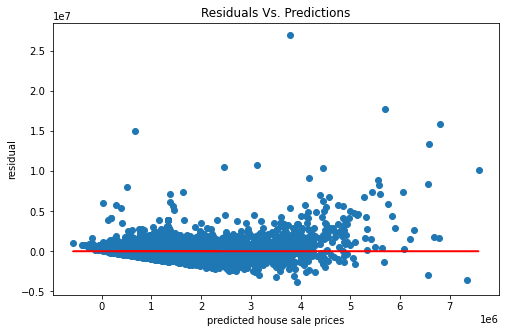

In [628]:

# calculating resid method 1
# model_L = model_mlr.predict(X)
# resid = Y - model_L
# x_res = model_L
# y_res = resid

# calculating resid method 2
resid = model_mlr.resid
x_res = model_mlr.predict()


fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x_res, resid)

slope, intercept, r, p, se = linregress(x_res,resid)
lin_r = linregress(x_res, resid)
plt.plot(x_res, lin_r.intercept + lin_r.slope*x_res, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('predicted house sale prices')
ax.set_ylabel('residual')
ax.set_title('Residuals Vs. Predictions');

# 2. Independence
Checking if errors are independent
- Create scatter plot of residuals and target values
    - Evaluete and identify patterns
- Check Durbin-Watson Statistic

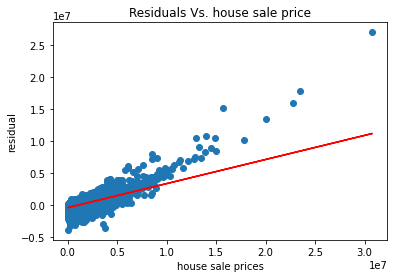

In [629]:
fig, ax = plt.subplots()
ax.scatter(Y, resid)

slope, intercept, r, p, se = linregress(Y,resid)
lin_r = linregress(Y, resid)
plt.plot(Y, lin_r.intercept + lin_r.slope*Y, 'r')

ax.set_xlabel('house sale prices')
ax.set_ylabel('residual')
ax.set_title('Residuals Vs. house sale price');

- Upward trend in this scatter plot indicates positive correlation in the errors

### Durbin-Watson
- Checks for autocorrelation in the residuals.
- Autocorrelation occurs when residuals are not independent.
- The range is from 0-4 
- values close to 2 indcate no significant autocorrelation (1.5 - 2.5)
- Values below 2 indicate positive autocorrelation
- Values above 2 indicate negative autocorrelation

In [630]:
dw = sm.stats.stattools.durbin_watson
dw(resid)

1.6200840922918573

Our autocorrelation from the Durbin-Watson test indicates a little to no signifcant autocorrelation

Possible positive auto correlation

In [631]:
model_mlr.summary().tables[2]

Omnibus:,48761.006,Durbin-Watson:,1.620
Prob(Omnibus):,0.000,Jarque-Bera (JB):,140901974.679
Skew:,10.842,Prob(JB):,0.00
Kurtosis:,342.792,Cond. No.,82.7


## 3. Normality

### Histograms

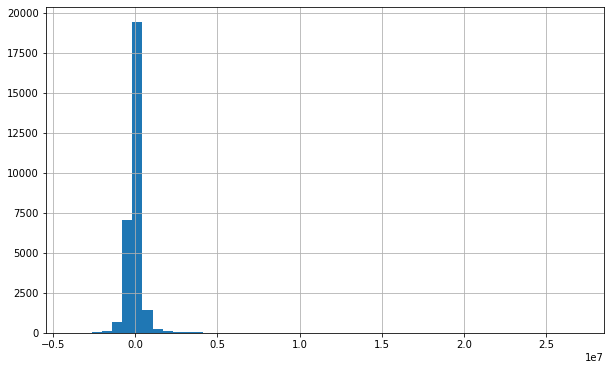

In [632]:
resid.hist(bins=50,figsize=(10,6));

Resizing the histogram to remove outliers

In [633]:
# resid[abs(resid) < 2500000].hist(bins=50,figsize=(10,6));

### QQ Plot

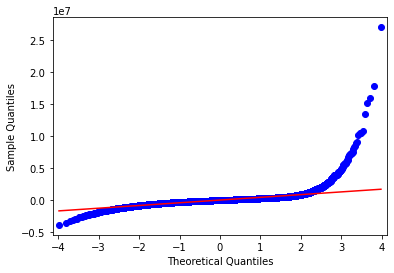

In [634]:
sm.qqplot(resid, line='r');

Slope: 1.000000000000001
Intercept: -2.561137080192566e-09
Correlation: (r) 0.7896195526449651


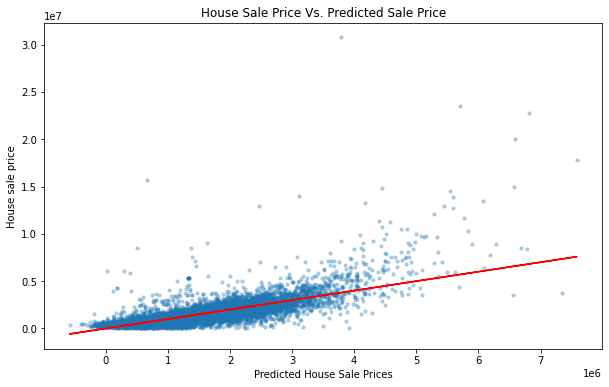

In [635]:
fig, ax = plt.subplots(figsize=(10,6))

# if Y is df_clean5['price']:
# x_pre = np.exp(model_mlr.predict(X))
# y_pre = np.exp(Y)
# elif Y == df_full_sc['price']: 

x_pre = model_mlr.predict(X)
y_pre = Y



ax.scatter(x_pre, y_pre,s=10,alpha=.3)

slope, intercept, r, p, se = linregress(x_pre,y_pre)
lin_r = linregress(x_pre, y_pre)
plt.plot(x_pre, lin_r.intercept + lin_r.slope*x_pre, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('Predicted House Sale Prices')
ax.set_ylabel('House sale price')
ax.set_title('House Sale Price Vs. Predicted Sale Price');

In [516]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Mean squared error
# mse = mean_squared_error(x_pre,y_pre)
# print("Mean Squared Error (MSE):", mse)

# # Mean absolute error
# mae = mean_absolute_error(x_pre,y_pre)
# print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 230535.5375599474


# Transformations

In [ ]:
def kde_plot(xy,x_label,legends=False):
    '''
    xy: Y or X
    x_label: str name for Y or X
    legends: set to True, to show
    Example for what x or y would look like:
    y = df['column']
    x = df[['column1','columns2','column3']]
    
    Example: kde_plot(Y,'price') where Y= df['price']

    '''
    name = str(xy)
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.kdeplot(data=xy,legend=legends, ax=ax)
    plt.title(f'KDE plot of {x_label}')
    plt.xlabel(x_label)
    plt.ylabel('Density')

In [ ]:
kde_plot(np.log(Y),'price')

In [ ]:
x_tester = df_clean[['bathrooms','bedrooms']]
kde_plot(x_tester,'variables',True)

In [ ]:
# Create a 5x8 grid of subplots for the KDE plots
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(16, 10))

# Flatten the grid of subplots into a 1D array
axes = axes.flatten()

# Loop through each variable and plot its KDE on a subplot
for k, v in enumerate(X.columns):
    sns.kdeplot(data=X[v], ax=axes[k], color='red')
    axes[k].set_title(v)

# Adjust the spacing between the subplots and show the plot
plt.tight_layout()
plt.show()

### Checking Distribution of Price

<AxesSubplot:>

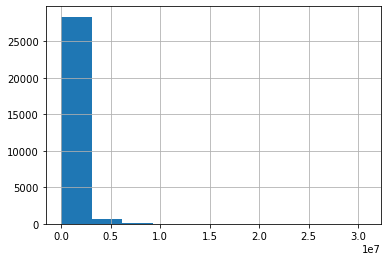

In [517]:
df_clean['price'].hist()

<AxesSubplot:>

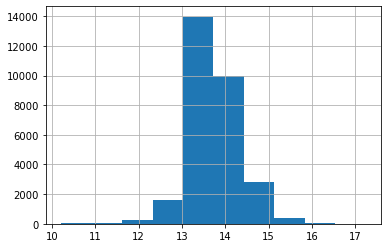

In [518]:
x_logged = np.log(df_clean['price'])
x_logged.hist()

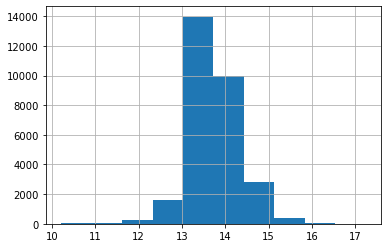

In [519]:
Y.hist();

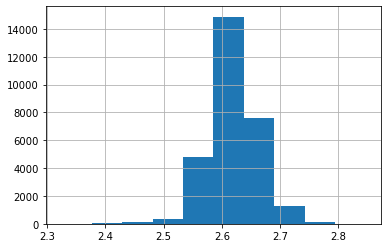

In [520]:
y_scld = np.log(Y)
y_scld.hist();

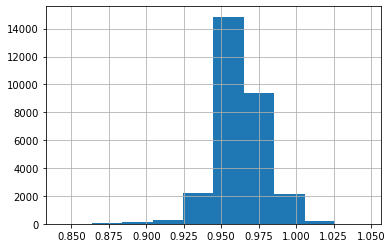

In [521]:
y_scld2 = np.log(y_scld)
y_scld2.hist();

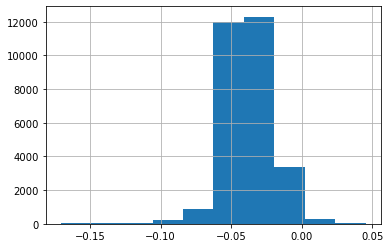

In [522]:
y_scld3 = np.log(y_scld2)
y_scld3.hist();

# Model 3

In [523]:
df_clean3 = df_full_sc.copy()
# df_clean3['sqft_living'] = np.log(df_clean3['sqft_living'])
# df_clean3['price'] = np.log(df_clean3['price'])
# remove3 = ['toxic_rele','sqft_above','sqft_lot','sqft_basement', 'sqft_garage', 'sqft_patio','MHHI1']
# df_clean3 = df_clean3.drop(columns=remove3)
model_clean3 = mlr(df_clean3,'price')
model_clean3

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     932.8
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:29:03   Log-Likelihood:                -27089.
No. Observations:               29170   AIC:                         5.428e+04
Df Residuals:                   29117   BIC:                         5.472e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.1146      0.010     11.371      0.000       0.095       0.134
bedrooms                           -0.0865      0.005    -17.376      0.000      -0.096      -0.077
bathrooms                           0.0615      0.007      9.214      0.000       0.048       0.075
sqft_living                         0.1404      0.017      8.503      0.000       0.108       0.173
sqft_lot                            0.0367      0.004      9.250      0.000       0.029       0.044
floors                             -0.0669      0.005    -12.172      0.000      -0.078      -0.056
condition                           0.0295      0.004      7.215      0.000       0.022       0.038
grade                               0.1559      0.007     23.606      0.000       0.143       0.169
sqft_above                          0.3015      0.015     19.868      0.000       0.272       0.331
sqft_basement                       0.0617      0.008      8.156      0.000       0.047       0.077
sqft_garage                        -0.0322      0.005     -6.093      0.000      -0.043      -0.022
sqft_patio                          0.0238      0.004      5.744      0.000       0.016       0.032
yr_built                           -0.0445      0.006     -7.134      0.000      -0.057      -0.032
MHHI1                               0.1345      0.005     26.159      0.000       0.124       0.145
traffic_de                          0.0365      0.004      8.901      0.000       0.028       0.045
toxic_rele                         -0.0123      0.005     -2.707      0.007      -0.021      -0.003
hazardou_2                         -0.0975      0.009    -10.314      0.000      -0.116      -0.079
waterfront                          0.9076      0.033     27.313      0.000       0.842       0.973
greenbelt                          -0.0787      0.023     -3.395      0.001      -0.124      -0.033
nuisance                           -0.0243      0.010     -2.465      0.014      -0.044      -0.005
renovated                           0.0718      0.018      3.883      0.000       0.036       0.108
SCHDST_210                         -0.3935      0.024    -16.331      0.000      -0.441      -0.346
SCHDST_216                         -0.6247      0.027    -22.965      0.000      -0.678      -0.571
SCHDST_400                          0.6308      0.037     17.143      0.000       0.559       0.703
SCHDST_401                         -0.1816      0.021     -8.468      0.000      -0.224      -0.140
SCHDST_402                         -0.3653      0.048     -7.585      0.000      -0.460      -0.271
SCHDST_403                         -0.1955      0.022     -8.699      0.000      -0.240      -0.151
SCHDST_404                         -0.7102      0.132     -5.366      0.000      -0

In [490]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2', 'renovated',
       'SCHDST_210', 'SCHDST_216', 'SCHDST_400', 'SCHDST_401', 'SCHDST_402',
       'SCHDST_403', 'SCHDST_404', 'SCHDST_405', 'SCHDST_406', 'SCHDST_407',
       'SCHDST_408', 'SCHDST_409', 'SCHDST_410', 'SCHDST_411', 'SCHDST_412',
       'SCHDST_414', 'SCHDST_415', 'SCHDST_417', 'SCHDST_888', 'view_AVERAGE',
       'view_EXCELLENT', 'view_FAIR', 'view_GOOD', 'sewer_system_PRIVATE',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED'],
      dtype='object')

# Model 4
In this model We drop all the years renovated from model 3

In [525]:
df_clean4 = df_full_sc.copy()
# df_clean4['sqft_living'] = np.log(df_clean4['sqft_living'])
# df_clean4['price'] = np.log(df_clean4['price'])
remove4 = ['greenbelt','sqft_garage','sqft_above', 'sqft_basement', 'sqft_patio']
df_clean4 = df_clean4.drop(columns=remove4)
model_clean4 = mlr(df_clean4,'price')
model_clean4

The following columns were dropped due to being object types
Index([], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1002.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:31:16   Log-Likelihood:                -27361.
No. Observations:               29170   AIC:                         5.482e+04
Df Residuals:                   29122   BIC:                         5.522e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0832      0.010      8.533      0.000       0.064       0.102
bedrooms                           -0.0881      0.005    -17.565      0.000      -0.098      -0.078
bathrooms                           0.0445      0.007      6.715      0.000       0.032       0.058
sqft_living                         0.4072      0.008     52.870      0.000       0.392       0.422
sqft_lot                            0.0410      0.004     10.273      0.000       0.033       0.049
floors                             -0.0169      0.005     -3.454      0.001      -0.026      -0.007
condition                           0.0188      0.004      4.625      0.000       0.011       0.027
grade                               0.1725      0.006     26.658      0.000       0.160       0.185
yr_built                           -0.0681      0.006    -11.278      0.000      -0.080      -0.056
MHHI1                               0.1351      0.005     26.058      0.000       0.125       0.145
traffic_de                          0.0374      0.004      9.044      0.000       0.029       0.046
toxic_rele                         -0.0114      0.005     -2.475      0.013      -0.020      -0.002
hazardou_2                         -0.1002      0.010    -10.501      0.000      -0.119      -0.081
waterfront                          0.9240      0.033     27.599      0.000       0.858       0.990
nuisance                           -0.0276      0.010     -2.780      0.005      -0.047      -0.008
renovated                           0.0642      0.019      3.458      0.001       0.028       0.101
SCHDST_210                         -0.3518      0.024    -14.777      0.000      -0.398      -0.305
SCHDST_216                         -0.5518      0.027    -20.538      0.000      -0.604      -0.499
SCHDST_400                          0.6588      0.037     17.841      0.000       0.586       0.731
SCHDST_401                         -0.1487      0.021     -6.945      0.000      -0.191      -0.107
SCHDST_402                         -0.3015      0.048     -6.227      0.000      -0.396      -0.207
SCHDST_403                         -0.1602      0.022     -7.187      0.000      -0.204      -0.116
SCHDST_404                         -0.6744      0.134     -5.050      0.000      -0.936      -0.413
SCHDST_405                          0.6588      0.020     33.540      0.000       0.620       0.697
SCHDST_406                         -0.0880      0.054     -1.644      0.100      -0.193       0.017
SCHDST_407                         -0.5105      0.033    -15.243      0.000      -0.576      -0.445
SCHDST_408                         -0.3760      0.024    -15.979      0.000      -0.422      -0.330
SCHDST_409                         -0.4457      0.024    -18.714      0.000      -0

In [ ]:
df_clean.columns

In [ ]:
cdf = df_clean.copy()

# remove4 = ['lat','long','date','toxic_rele','yr_renovated','sqft_above','sqft_lot','sqft_basement', 
#            'sqft_garage', 'sqft_patio','MHHI1','sqft_living']
# cdf_df = cdf.drop(columns=remove4)


cdf['sqft_living'] = np.log(cdf['sqft_living'])
cdf['yr_built'] = np.log(cdf['yr_built'])
# df_clean_3['price'] = y_scld#np.log(Y)


cdf_df = cdf[['price', 'bedrooms', 'bathrooms','sqft_living',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition',
       'grade', 'traffic_de','yr_built', 'hazardou_2']]
mlr(cdf_df,'price')

# Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [ ]:
# pf = PolynomialFeatures(degree=3)

# X = wine.drop('quality', axis=1)
# y = wine['quality']

# # Fitting the PolynomialFeatures object
# pf.fit(X)

In [ ]:
X1 = ['floors','MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2']
y1 = df_clean['price']

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].scatter(df_clean[X1[0]], y1)
axs[0].set_xlabel(f'{X1[0]}')
axs[0].set_ylabel('Price ($)')
axs[0].set_title(f'{X1[0]} vs. Price')

axs[1].scatter(df_clean[X1[1]], y1)
axs[1].set_xlabel(f'{X1[1]}')
axs[1].set_ylabel('Price ($)')
axs[1].set_title(f'{X1[1]} vs. Price')

axs[2].scatter(df_clean[X[2]], y1)
axs[2].set_xlabel(f'{X1[2]}')
axs[2].set_ylabel('Price ($)')
axs[2].set_title(f'{X1[2]} vs. Price')

plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(X,y); 

# ax.set_xlabel('Square Foot Living (ft)')
# ax.set_ylabel('Price ($)')
# ax.set_title('Price of Houses based on Square foot')

# plt.show()

In [ ]:
# sns.lmplot(data=df_cleaned_2, x='sqft_living', y='price')
# plt.xlabel('Sqft Living (sqft)')
# plt.ylabel('Price ($)')
# plt.title('Price against to Sqft Living');